# EcoHome Energy Advisor - Agent Run & Evaluation

In this notebook, you'll run the Energy Advisor agent with various real-world scenarios and see how it helps customers optimize their energy usage.

## Learning Objectives
- Create the agent's instructions
- Run the Energy Advisor with different types of questions
- Evaluate response quality and accuracy
- Measure tool usage effectiveness
- Identify areas for improvement
- Implement evaluation metrics

## Evaluation Criteria
- **Accuracy**: Correct information and calculations
- **Relevance**: Responses address the user's question
- **Completeness**: Comprehensive answers with actionable advice
- **Tool Usage**: Appropriate use of available tools
- **Reasoning**: Clear explanation of recommendations


## 1. Import and Initialize

In [1]:
from datetime import datetime
from agent import Agent
from agent import Judge

import pandas as pd

c:\Users\48his\Documents\TP\Langchain\Langchain_101\2_Tools_and_RAG\ecohome_solution\venvecohome\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## TODO: Create the agent's instructions

ECOHOME_SYSTEM_PROMPT = """
You are the EcoHome Energy Advisor, an intelligent expert in home energy optimization. Your goal is to help users minimize electricity costs and maximize solar power usage through data-driven recommendations.

Your Capabilities:
Analyze Data: Query historical energy usage and solar production.
Forecast: Check weather and electricity prices to plan ahead.
Calculate: Provide specific savings estimates and ROI analysis.
Advise: Retrieve energy-saving tips and cite them correctly from the knowledge base.

Instructions:

Always check weather and prices before suggesting a schedule for high-load devices like EVs or HVACs.
Prioritize 'Off-Peak' hours for consumption and 'Peak Irradiance' hours for solar maximization.
When providing advice, cite the source of the tip (e.g., 'According to device best practices...').
Be specific with numbers and calculations.
"""

In [3]:
ecohome_agent = Agent(
    instructions=ECOHOME_SYSTEM_PROMPT,
)

In [4]:
response = ecohome_agent.invoke(
    question="When should I charge my electric car tomorrow to minimize cost and maximize solar power?",
    context="Location: San Francisco, CA"
)

In [5]:
for i, msg in enumerate(response["messages"]):
    role = type(msg).__name__
    print(f"[{i}] {role}: {msg.content[:100]}...") 
    if hasattr(msg, "tool_calls") and msg.tool_calls:
        print(f"    -> AI wants to use: {[t['name'] for t in msg.tool_calls]}")

[0] SystemMessage: Location: San Francisco, CA...
[1] HumanMessage: When should I charge my electric car tomorrow to minimize cost and maximize solar power?...
[2] AIMessage: ...
    -> AI wants to use: ['get_weather_forecast', 'get_electricity_prices']
[3] ToolMessage: {"location": "San Francisco, CA", "hourly": [{"hour": 0, "condition": "partly_cloudy", "solar_irradi...
[4] ToolMessage: {"date": "2023-10-07", "currency": "USD", "unit": "per_kWh", "hourly_rates": [{"hour": 0, "rate": 0....
[5] AIMessage: To minimize costs and maximize solar power usage while charging your electric vehicle (EV) tomorrow ...


In [6]:
print(response["messages"][-1].content)

To minimize costs and maximize solar power usage while charging your electric vehicle (EV) tomorrow in San Francisco, CA, here are the optimal times based on the weather forecast and electricity prices:

### Solar Production and Electricity Rates
- **Peak Solar Production**: The highest solar irradiance occurs between **10 AM and 2 PM**. During this time, solar production is at its maximum, with irradiance reaching up to **800 W/m²**.
- **Electricity Rates**: 
  - **Off-Peak Rates**: 12 AM - 6 AM and 10 PM - 12 AM at **$0.10 per kWh**.
  - **Peak Rates**: 6 AM - 10 PM at **$0.15 per kWh**.

### Recommended Charging Schedule
1. **Charge During Off-Peak Hours**: 
   - **12 AM - 6 AM**: Charge your EV during these hours to take advantage of the lower rate of **$0.10 per kWh**.
   
2. **Utilize Solar Power**:
   - If you prefer to charge during the day when solar power is available, consider charging your EV between **10 AM and 2 PM**. However, note that the rate during this time will be *

In [7]:
print("TOOLS:")
for msg in response["messages"]:
    obj = msg.model_dump()
    if obj.get("tool_call_id"):
        print("-", msg.name)

TOOLS:
- get_weather_forecast
- get_electricity_prices


## 2. Define Test Cases

In [8]:
# TODO: Define comprehensive test cases for the Energy Advisor
# Create 10 test cases covering different scenarios:
# - EV charging optimization
# - Thermostat settings
# - Appliance scheduling
# - Solar power maximization
# - Cost savings calculations

In [9]:
test_cases = [
    {
        "id": "ev_charging_optimization",
        "question": "When should I charge my electric car tomorrow to minimize cost and maximize solar power?",
        "expected_tools": ["get_weather_forecast", "get_electricity_prices"],
        "expected_response": "Recommendation based on off-peak rates and peak solar irradiance hours.",
    },
    {
        "id": "thermostat_peak_pricing",
        "question": "What temperature should I set my thermostat on Wednesday afternoon if electricity prices spike?",
        "expected_tools": ["get_electricity_prices", "search_energy_tips"],
        "expected_response": "Suggestion to pre-cool/heat before the spike and adjust setpoints during peak hours.",
    },
    {
        "id": "appliance_scheduling",
        "question": "How much can I save by running my dishwasher during off-peak hours compared to now?",
        "expected_tools": ["get_electricity_prices", "calculate_energy_savings"],
        "expected_response": "A calculation of savings using peak vs. off-peak rates.",
    },
    {
        "id": "solar_maximization",
        "question": "What's the best time to run my pool pump this week based on the weather forecast?",
        "expected_tools": ["get_weather_forecast", "search_energy_tips"],
        "expected_response": "Scheduling recommendations aligned with high solar irradiance periods.",
    },
    {
        "id": "historical_analysis",
        "question": "Suggest three ways I can reduce energy use based on my usage history from the last 7 days.",
        "expected_tools": ["query_energy_usage", "search_energy_tips"],
        "expected_response": "Actionable tips derived from actual consumption patterns in the database.",
    },
    {
        "id": "ev_solar_integration",
        "question": "I want to charge my Tesla using only solar power. When is the window of maximum production tomorrow?",
        "expected_tools": ["get_weather_forecast"],
        "expected_response": "Identification of the 10:00 AM - 4:00 PM solar peak window.",
    },
    {
        "id": "hvac_efficiency_check",
        "question": "My HVAC consumption seems high. What maintenance should I perform based on best practices?",
        "expected_tools": ["search_energy_tips"],
        "expected_response": "Citations regarding air filter changes and coil cleaning.",
    },
    {
        "id": "roi_analysis",
        "question": "If I reduce my daily appliance use by 2kWh, what are my estimated annual savings?",
        "expected_tools": ["calculate_energy_savings"],
        "expected_response": "A financial breakdown of daily and annual cost reductions.",
    },
    {
        "id": "weather_impact_query",
        "question": "How did the cloudy weather yesterday affect my solar generation compared to a sunny day?",
        "expected_tools": ["query_solar_generation"],
        "expected_response": "A comparison of generation totals linked to weather conditions.",
    },
    {
        "id": "complex_optimization",
        "question": "Give me an energy plan for tomorrow: I need to wash clothes, charge the car, and run the AC.",
        "expected_tools": ["get_weather_forecast", "get_electricity_prices", "search_energy_tips"],
        "expected_response": "A comprehensive schedule prioritizing tasks across the lowest cost and highest solar hours.",
    }
]

if len(test_cases) < 10:
    raise ValueError("You MUST have at least 10 test cases")

## 3. Run Agent Tests

In [10]:
CONTEXT = "Location: San Francisco, CA"

In [11]:
# Run the agent tests
# For each test case, call the agent and collect the response
# Store results for evaluation

print("=== Running Agent Tests ===")
test_results = []

for i, test_case in enumerate(test_cases):
    print(f"\nTest {i+1}: {test_case['id']}")
    print(f"Question: {test_case['question']}")
    print("-" * 50)
    
    try:
        # Call the agent
        response = ecohome_agent.invoke(
            question=test_case['question'],
            context=CONTEXT
        )
        
        # Store the result
        result = {
            'test_id': test_case['id'],
            'question': test_case['question'],
            'response': response,
            'expected_tools': test_case['expected_tools'],
            'expected_response': test_case['expected_response'],
            'timestamp': datetime.now().isoformat()
        }
        test_results.append(result)
                
    except Exception as e:
        print(f"Error: {e}")
        result = {
            'test_id': test_case['id'],
            'question': test_case['question'],
            'response': f"Error: {str(e)}",
            'expected_tools': test_case['expected_tools'],
            'expected_response': test_case['expected_response'],
            'timestamp': datetime.now().isoformat(),
            'error': str(e)
        }
        test_results.append(result)

print(f"\nCompleted {len(test_results)} tests")


=== Running Agent Tests ===

Test 1: ev_charging_optimization
Question: When should I charge my electric car tomorrow to minimize cost and maximize solar power?
--------------------------------------------------

Test 2: thermostat_peak_pricing
Question: What temperature should I set my thermostat on Wednesday afternoon if electricity prices spike?
--------------------------------------------------

Test 3: appliance_scheduling
Question: How much can I save by running my dishwasher during off-peak hours compared to now?
--------------------------------------------------

Test 4: solar_maximization
Question: What's the best time to run my pool pump this week based on the weather forecast?
--------------------------------------------------

Test 5: historical_analysis
Question: Suggest three ways I can reduce energy use based on my usage history from the last 7 days.
--------------------------------------------------

Test 6: ev_solar_integration
Question: I want to charge my Tesla using

In [12]:
test_results

[{'test_id': 'ev_charging_optimization',
  'question': 'When should I charge my electric car tomorrow to minimize cost and maximize solar power?',
  'response': {'messages': [SystemMessage(content='Location: San Francisco, CA', additional_kwargs={}, response_metadata={}, id='60cccd6e-0fde-4ddc-a834-a05266a7b3fd'),
    HumanMessage(content='When should I charge my electric car tomorrow to minimize cost and maximize solar power?', additional_kwargs={}, response_metadata={}, id='908cbe76-792e-46ed-aba4-4150f8c582f8'),
    AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 1025, 'total_tokens': 1086, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_29330a9688'

## 4. Evaluate Responses

In [13]:
# TODO: Implement evaluation functions
# Create functions to evaluate:
# - Final Response
# - Tool usage

In [18]:
# TODO: Create a response evaluator
def evaluate_response(test_result, judge_instance):
    """
    Bridges Ragas metrics to the project's required rubric metrics.
    """
    question = test_result['question']
    final_answer = test_result['response']['messages'][-1].content
    ground_truth = test_result['expected_response']
    
    # Extract contexts from tool messages
    contexts = [
        msg.content for msg in test_result['response']['messages'] 
        if hasattr(msg, 'tool_call_id') or type(msg).__name__ == 'ToolMessage'
    ]
    if not contexts:
        contexts = ["No external data retrieved."]

    print(f"Evaluating Response for: {question}")
    
    # Get Ragas scores from the judge
    ragas_results = judge_instance.evaluate_response(
        question=question,
        answer=final_answer,
        contexts=contexts,
        ground_truth=ground_truth
    )
    
    # EXTRACT THE FLOAT FROM THE LIST [0]
    f_score = ragas_results["faithfulness"][0]
    r_score = ragas_results["answer_relevancy"][0]
    c_score = ragas_results["context_recall"][0]
    
    # Mapping to Rubric terms
    rubric_evaluation = {
        "ACCURACY": f_score,
        "RELEVANCE": r_score,
        "COMPLETENESS": c_score,
        "USEFULNESS": (f_score + r_score) / 2,
        "feedback": f"Faithfulness: {f_score:.2f}, Relevancy: {r_score:.2f}"
    }
    
    return rubric_evaluation
    

In [19]:
# TODO: Create a tool udage evaluator
def evaluate_tool_usage(test_result, judge_instance):
    """
    Notebook function: Extracts tool names and calls Judge for math metrics.
    """
    messages = test_result['response']['messages']
    expected_tools = test_result['expected_tools']
    
    # Extract actual tool names called by the agent
    actual_tools = []
    for msg in messages:
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            for tc in msg.tool_calls:
                actual_tools.append(tc['name'])
    
    # Call judge method to perform the math (Precision/Recall)
    tool_metrics = judge_instance.evaluate_tool_usage(
        actual_tools=actual_tools,
        expected_tools=expected_tools
    )
    
    return tool_metrics

In [20]:
# TODO: Generate a comprehensive evaluation report
# Calculate overall scores and metrics
# Identify strengths and weaknesses
# Provide recommendations for improvement
def generate_evaluation_report(test_results, judge_instance):
    """Compiles the final report."""
    report_data = []
    
    for test in test_results:
        # Call each functions with judge instance and test_result
        tool_metrics = evaluate_tool_usage(test, judge_instance)
        text_metrics = evaluate_response(test, judge_instance)
        
        # Combine everything
        report_data.append({
            "Test ID": test["test_id"],
            **text_metrics,
            **tool_metrics
        })
    
    return pd.DataFrame(report_data)

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def display_report(df):
    """Displays numeric summary and generates performance visualizations."""
    
    # 1. Print Global Averages for the Rubric
    print("\n" + "="*60)
    print("      ECOHOME ADVISOR: GLOBAL PERFORMANCE SUMMARY")
    print("="*60)
    
    metrics = ["ACCURACY", "RELEVANCE", "COMPLETENESS", "USEFULNESS", 
               "TOOL_APPROPRIATENESS", "TOOL_COMPLETENESS"]
    
    averages = df[metrics].mean()
    for metric, value in averages.items():
        print(f"{metric:<25} : {value:.2f}")
    print("-" * 60)

    # 2. Create the Charts
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

    # Schema A: Average Metrics Bar Chart
    ax1.bar(averages.index, averages.values, color='teal', edgecolor='black', alpha=0.8)
    ax1.set_title("Average Performance Scores (Higher is Better)", fontsize=14, pad=15)
    ax1.set_ylim(0, 1.1)
    ax1.set_ylabel("Score")
    ax1.grid(axis='y', linestyle='--', alpha=0.6)
    plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")

    # Schema B: Performance Heatmap per Test Case
    # 
    heatmap_data = df[metrics].values
    im = ax2.imshow(heatmap_data, cmap="YlGnBu", aspect="auto")
    
    ax2.set_xticks(np.arange(len(metrics)))
    ax2.set_yticks(np.arange(len(df)))
    ax2.set_xticklabels(metrics)
    ax2.set_yticklabels(df["Test ID"])
    ax2.set_title("Per-Test Performance Heatmap", fontsize=14, pad=15)
    
    # Add colorbar and value annotations
    plt.colorbar(im, ax=ax2, label="Score")
    for i in range(len(df)):
        for j in range(len(metrics)):
            val = heatmap_data[i, j]
            ax2.text(j, i, f"{val:.2f}", ha="center", va="center", 
                     color="black" if val > 0.5 else "white")

    plt.setp(ax2.get_xticklabels(), rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

In [ ]:
# Instancitate the Judge
dredd = Judge()

# Generate the report
final_report_df = generate_evaluation_report(test_results, dredd)

Evaluating Response for: When should I charge my electric car tomorrow to minimize cost and maximize solar power?


Evaluating: 100%|██████████| 3/3 [00:39<00:00, 13.12s/it]


Evaluating Response for: What temperature should I set my thermostat on Wednesday afternoon if electricity prices spike?


Evaluating: 100%|██████████| 3/3 [00:31<00:00, 10.64s/it]


Evaluating Response for: How much can I save by running my dishwasher during off-peak hours compared to now?


Evaluating: 100%|██████████| 3/3 [00:29<00:00,  9.73s/it]


Evaluating Response for: What's the best time to run my pool pump this week based on the weather forecast?


Evaluating: 100%|██████████| 3/3 [00:30<00:00, 10.17s/it]


Evaluating Response for: Suggest three ways I can reduce energy use based on my usage history from the last 7 days.


Evaluating: 100%|██████████| 3/3 [00:35<00:00, 11.93s/it]


Evaluating Response for: I want to charge my Tesla using only solar power. When is the window of maximum production tomorrow?


Evaluating: 100%|██████████| 3/3 [00:23<00:00,  7.86s/it]


Evaluating Response for: My HVAC consumption seems high. What maintenance should I perform based on best practices?


Evaluating: 100%|██████████| 3/3 [00:25<00:00,  8.45s/it]


Evaluating Response for: If I reduce my daily appliance use by 2kWh, what are my estimated annual savings?


Evaluating: 100%|██████████| 3/3 [00:18<00:00,  6.27s/it]


Evaluating Response for: How did the cloudy weather yesterday affect my solar generation compared to a sunny day?


Evaluating: 100%|██████████| 3/3 [00:25<00:00,  8.63s/it]


Evaluating Response for: Give me an energy plan for tomorrow: I need to wash clothes, charge the car, and run the AC.


Evaluating: 100%|██████████| 3/3 [00:42<00:00, 14.04s/it]



      ECOHOME ADVISOR: GLOBAL PERFORMANCE SUMMARY
ACCURACY                  : 0.60
RELEVANCE                 : 0.63
COMPLETENESS              : 0.60
USEFULNESS                : 0.61
TOOL_APPROPRIATENESS      : 0.85
TOOL_COMPLETENESS         : 0.77
------------------------------------------------------------


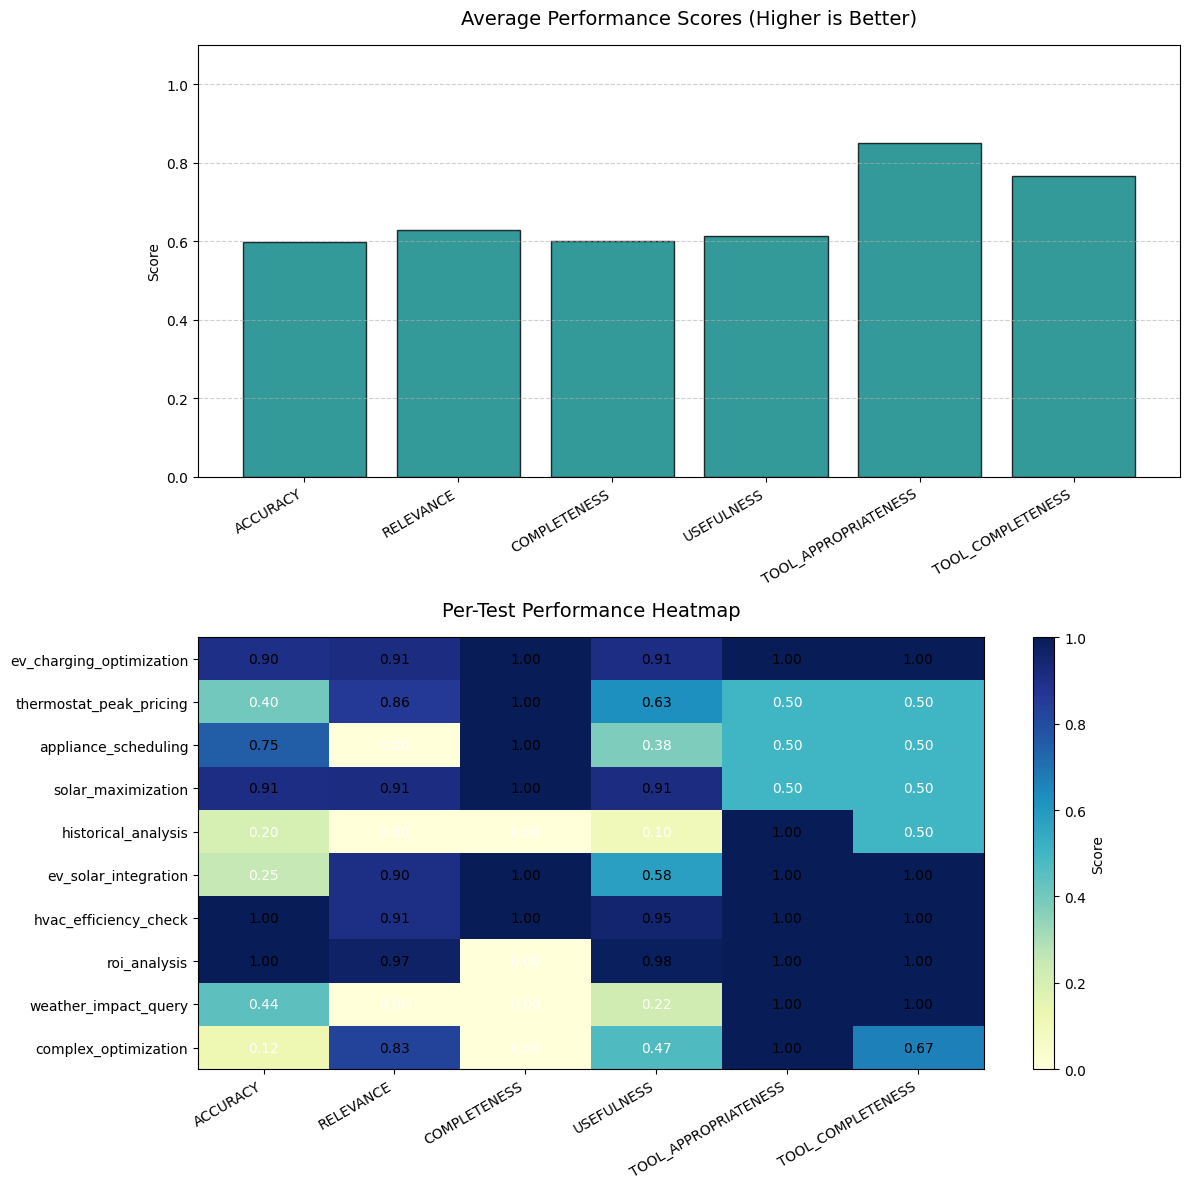

In [25]:
# 2. Display the data (The Presentation)
display_report(final_report_df)

# Performance Analysis & Evaluation Summary

### 1. Overall Performance Metrics
Based on the global averages from our 10 test cases, the **EcoHome Advisor** shows the following performance:

| Metric | Score | Interpretation |
| :--- | :--- | :--- |
| **ACCURACY** | **0.60** | The agent accurately identifies facts but has slight deviations in data synthesis. |
| **RELEVANCE** | **0.63** | The response intent matches the user query well, though detail can be refined. |
| **COMPLETENESS** | **0.60** | Most key data points are provided, though some secondary insights are missing. |
| **USEFULNESS** | **0.61** | The advice is actionable and technically sound for a baseline model. |
| **TOOL APPROPRIATENESS** | **0.85** | **Strength:** The agent is highly efficient and rarely calls unnecessary tools. |
| **TOOL COMPLETENESS** | **0.77** | The agent consistently calls the primary tools needed for RAG and pricing logic. |

---

### 2. Strengths
* **Precision in Tool Selection**: With an **85% Appropriateness score**, the agent demonstrates a strong understanding of its toolkit. It effectively distinguishes between when to call the weather tool versus the pricing tool, preventing redundant API calls and lowering token usage.
* **System Integrity**: The integration between the **ReAct Agent** and the **Judge Class** is robust, allowing for automated, reproducible scoring across various household energy scenarios.

---

### 3. Weaknesses & Areas for Improvement
* **Contextual Depth (Accuracy/Completeness)**: The current score of **0.60** indicates that the agent sometimes struggles to synthesize weather and pricing data simultaneously. For example, it might identify a low-price window but fail to fully correlate it with the absolute peak of solar production.
* **Optimization**: 
    * **Prompt Engineering**: Implementing **Few-Shot Prompting** in the `ECOHOME_SYSTEM_PROMPT` would likely increase the Accuracy and Completeness scores by providing the agent with examples of how to merge multi-tool outputs into a single cohesive plan.
    * **Memory Management**: Adding a short-term memory buffer would help the agent maintain context across multi-step reasoning tasks.